# Setting boundary conditions in PorePy
In this tutorial we will visit how to set boundary conditions for different model problems in PorePy.
In general, the setup is roughly as follows:
* Boundary condition type (Neumann or Dirichlet) is set by one method
* Boundary condition values are set through one or more methods

Internally in the code there are Neumann and Dirichlet filters being assigned according to the user's input in the boundary condition type method.
These filters make sure that only values set by a Dirichlet-method is assigned to Dirichlet boundaries, and similar for the Neumann case. For explaining this more thoroughly we will present some examples.


In [1]:
from porepy.applications.md_grids.domains import nd_cube_domain
import numpy as np
import porepy as pp


class ModifiedGeometry:
    def set_domain(self) -> None:
        """Defining a two-dimensional square domain with sidelength 2."""
        size = self.solid.convert_units(2, "m")
        self._domain = nd_cube_domain(2, size)

    def grid_type(self) -> str:
        """Choosing the grid type for our domain."""
        return self.params.get("grid_type", "cartesian")

    def meshing_arguments(self) -> dict:
        """Meshing arguments for md-grid creation."""
        cell_size = self.solid.convert_units(0.25, "m")
        mesh_args: dict[str, float] = {"cell_size": cell_size}
        return mesh_args

# Basics
PorePy provides several ways to tailor the boundary conditions for your problem.
All methods for setting them follow the convension. To set a boundary condition for a `physical_quantity`, such as `pressure`, do the following:

1) Specify the type of the boundary condition (Dirichlet, Neumann or Robert) in the method named `bc_type_<physical_quantity>`.
2) Set the values of the physical quantity on the boundary in the method named `bc_values_<physical_quantity>`.

Some of the possible physical quantities will be listed below in this tutorial. All the possible values can be found in the source code of the `BoundaryConditionMixin` of the corresponding model, for example:

In [2]:
for x in dir(pp.models.fluid_mass_balance.BoundaryConditionsSinglePhaseFlow):
    if x.startswith('bc_values') or x.startswith('bc_type'):
        print(x)

bc_type_darcy_flux
bc_type_fluid_flux
bc_values_darcy_flux
bc_values_fluid_flux
bc_values_pressure


Let us consider the basic example of setting these boundary conditions for the single-phase flow model:

* West boundary: constant Neumann in-flux in the middle of the side, no flux elsewhere.
* East boundary: constant nonzero Dirichlet pressure.
* South and north boundaries: no flux.

The type of a boundary condition is set with the `pp.BoundaryCondition` class. By default, it sets all the boundary cells to Neumann. You can provide the sides to apply the Dirichlet boundary conditions. Also, note how we access the domain sides with the `domain_boundary_sides` method.

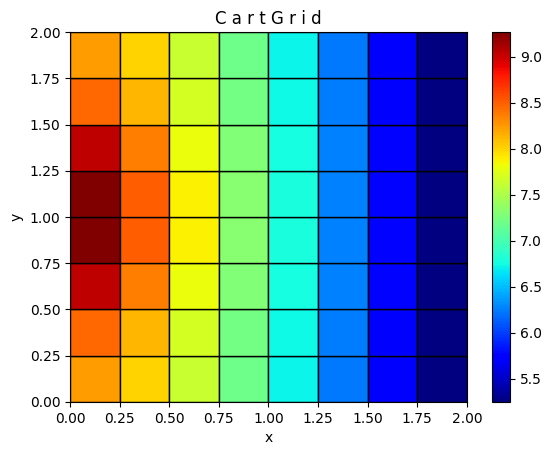

In [6]:
from porepy.models.fluid_mass_balance import SinglePhaseFlow


class SinglePhaseFlowExample1(ModifiedGeometry, SinglePhaseFlow):
    def bc_type_fluid_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Setting the Dirichlet type on the east boundary, Neumann elsewhere."""
        domain_sides = self.domain_boundary_sides(sd)
        return pp.BoundaryCondition(sd, faces=domain_sides.east, cond="dir")

    def bc_values_fluid_flux(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Setting the values of the fluid mass flux."""
        mass_flux_vals = np.zeros(boundary_grid.num_cells)

        domain_sides = self.domain_boundary_sides(boundary_grid)
        influx_cells = np.zeros(boundary_grid.num_cells, dtype=bool)
        influx_cells[domain_sides.west] = True
        # Setting the values on the west boundary where 0.5 < y < 1.5
        influx_cells &= boundary_grid.cell_centers[1] > 0.5
        influx_cells &= boundary_grid.cell_centers[1] < 1.5

        mass_flux_vals[influx_cells] = -1 * self.units.kg / self.units.s
        return mass_flux_vals

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        pressure_vals = np.zeros(boundary_grid.num_cells)
        domain_sides = self.domain_boundary_sides(boundary_grid)
        pressure_vals[domain_sides.east] = 5 * self.units.Pa
        return pressure_vals


single_phase_flow = SinglePhaseFlowExample1(params={})
pp.run_time_dependent_model(single_phase_flow, params={})
pressure = (
    single_phase_flow.pressure(single_phase_flow.mdg.subdomains())
    .evaluate(single_phase_flow.equation_system)
    .val
)
pp.plot_grid(single_phase_flow.mdg.subdomains()[0], pressure, plot_2d=True)

The Dirichlet pressure values of 5 Pa on the east boundary affect the pressure in the whole system, and we observe the pressure drop from the west to the east which corresponds to the flux from the west boundary.

# Single-phase fluid
There are several approaches of how to set the boundary conditions for the single-phase flow problem. We list them here.

## 1. Setting the fluid mass flux
Consider the mass balance equation with zero source term:
$\phi \dfrac{\partial \rho}{\partial t} + \nabla \cdot F = 0$, where $\phi \frac{\partial \rho}{\partial t}$ is the accumulation term, and $F$ is the fluid mass flux that flows in a cell. We can directly set the values of $F$ on boundary by:
* marking the boundary faces as `neu` in the `bc_type_fluid_flux` method
* providing the values of $F$ in `bc_values_fluid_flux`

Note that we provide only the normal component of $F$. If cells are marked as `dir` in `bc_type_fluid_flux`, the values of $F$ are computed based on the other types of boundary conditions.

Pro hint: the no-flux boundary condition can be applied by setting the zero values here.

We used this type of boundary condition in the example above.

## 2. Setting the Darcy flux
The expression for $F$ is the following: $F = -\dfrac{\rho}{\mu}K \nabla p$, where $\dfrac{\rho}{\mu}$ is the advected quantity and $-K \nabla p$ is the Darcy flux.

In realistic setups, the values of $\rho$ and $\mu$ can depend on primary variables. For example, $\rho = \rho(p, T)$ and $\mu = \mu(T)$ in case of the non-isothermal fluid. It may be convenient to set the boundary condition in terms of the Darcy flux. The values for the advected quantity will be computed automatically. This helps prevent inconsistencies between expressions used to calculate these quantities on the boundary versus within the domain, which can cause notorious bugs. The Darcy flux boundary condition is applied by:
* ensuring that we do not use the boundary values for $F$ by checking that `bc_type_fluid_flux == dir` for our boundary faces
* setting the boundary faces as `neu` in `bc_type_darcy_flux`
* setting the values of primary variables that are used to evaluate $\rho$ and $\mu$ on the boundary in `bc_values_pressure` and the other methods corresponding to each variable in use
* setting the values for the Darcy flux in `bc_values_darcy_flux`

We will set this boundary condition at the west side of the domain in the example below.

## 3. Setting pressure Dirichlet values
Finally, the Darcy flux can be evaluated by the provided pressure values. This is done by:
* ensuring that we do not use the boundary values for $F$ by checking that `bc_type_fluid_flux == dir` for our boundary faces
* setting the boundary faces as `dir` in `bc_type_darcy_flux`
* setting pressure values on the boundary in `bc_values_pressure`

We used this type of boundary condition in the example above.



Now, we will us run the model with the Darcy flux boundary condition. The setup will use the same values for the boundary conditions as in the example above. To demonstrate the advantage of the Darcy flux boundary condition, we will increase the fluid viscosity $\mu$ by 10 times and see what will happen: 

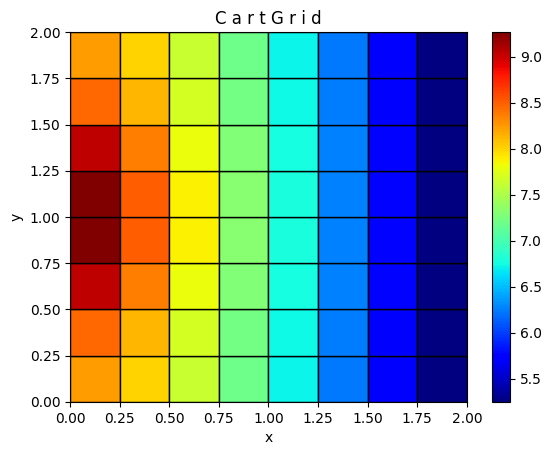

In [4]:
import numpy as np
import porepy as pp
from porepy.models.fluid_mass_balance import SinglePhaseFlow


class SinglePhaseFlowExample2(ModifiedGeometry, SinglePhaseFlow):
    # Note that now this is bc_type_darcy_flux, not the bc_type_fluid_flux.
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Everything is the same as in the previous example."""
        domain_sides = self.domain_boundary_sides(sd)
        return pp.BoundaryCondition(sd, faces=domain_sides.east, cond="dir")

    # Note that now this is bc_values_darcy_flux, not the bc_values_fluid_flux.
    def bc_values_darcy_flux(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Setting the Darcy flux values on the west boundary."""
        darcy_flux_vals = np.zeros(boundary_grid.num_cells)

        # Same as in the previous example
        domain_sides = self.domain_boundary_sides(boundary_grid)
        influx_cells = np.zeros(boundary_grid.num_cells, dtype=bool)
        influx_cells[domain_sides.west] = True
        influx_cells &= boundary_grid.cell_centers[1] > 0.5
        influx_cells &= boundary_grid.cell_centers[1] < 1.5

        # The value is the same
        darcy_flux_vals[influx_cells] = -1 * self.units.Pa / self.units.m
        return darcy_flux_vals

    # This method did not change.
    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Everything is the same as in the previous example."""
        pressure_vals = np.zeros(boundary_grid.num_cells)
        domain_sides = self.domain_boundary_sides(boundary_grid)
        pressure_vals[domain_sides.east] = 5 * self.units.Pa
        return pressure_vals


single_phase_flow = SinglePhaseFlowExample2(
    params={
        "material_constants": {
            "fluid": pp.FluidConstants(
                {
                    "viscosity": 10,  # 10 times larger than in the previous example.
                }
            )
        }
    }
)
pp.run_time_dependent_model(single_phase_flow, params={})
pressure = (
    single_phase_flow.pressure(single_phase_flow.mdg.subdomains())
    .evaluate(single_phase_flow.equation_system)
    .val
)
pp.plot_grid(single_phase_flow.mdg.subdomains()[0], pressure, plot_2d=True)

The flux did not change, this is the expected behavior. The Darcy flux BC automatically applies the correct values of the convected quantity (it includes $\mu$) to the boundary. However, if we used the `fluid_flux_bc_values` and changed $\mu$, the flux would also change, as it knows nothing about the convected quantity! It could potentially lead to an error, if we computed the flux manually based on the old value of $\mu$ and forgot to recompute it.

Excercise: apply the different $\mu$ to the first example and see how the fluid flux changes.

# The mechanics problem
Similar to the previous problems, we need to define one method for the type of boundary condition we are interested in, and another one for assigning the values. 
In the case of the mechanics problem we utilize the momentum balance model class. 
The momentum balance model class has the following methods predefined for setting boundary condition type and values:
* `bc_type_mechanics` for setting boundary condition type.
* `bc_values_displacement` for Dirichlet values.
* `bc_values_stress` for Neumann values.

As opposed to with the previous examples, this is a vector problem. 
Therefore we will here have to assign vectorial boundary condition values. 
This is shown below:


In [5]:
import numpy as np
import porepy as pp

class ModifiedBoundaryConditions:
    def bc_type_mechanics(self, sd: pp.Grid) -> pp.BoundaryConditionVectorial:
        bounds = self.domain_boundary_sides(sd)

        bc = pp.BoundaryConditionVectorial(sd, bounds.west, "dir")
        return bc

    def bc_values_stress(self, bg: pp.BoundaryGrid) -> np.ndarray:
        """Setting stress boundary conditions at north, south and east boundaries.
        
        Specifically, we assign different values for the x- and y-component of the boundary value vector.

        """
        values = np.ones((self.nd, bg.num_cells))
        bounds = self.domain_boundary_sides(bg)

        values[0][bounds.north + bounds.south] *= 1.5
        values[1][bounds.north + bounds.south] *= 0.5

        return values.ravel("F")

    def bc_values_displacement(self, bg: pp.BoundaryGrid) -> np.ndarray:
        """Setting displacement boundary conditions.
        
        This method returns an array of boundary condition values with the value 5 for all boundary x-components. However, since only the western boundary has the Dirichlet filter, the internal code will only consider the value 5 for the western boundary.
        
        """
        values = np.ones((self.nd, bg.num_cells))
    
        values[0] *= 5
        return values.ravel("F")


TODO: Time-dependent bc